# CosmoDC2 - Movies

# CosmoDC2: The Movie (feat. Apache Spark)

<br> Kernel: **desc-pyspark**
<br> Author: **LAL team**
<br> Last Verified to Run: **2018-12-20**
    
The goal of this notebook is to have a first 3D look at the latest DC2 extragalatic catalog (v1.1.4) using Apache Spark.
The use of Jupyter notebook at NERSC being (currently) memory limited, is not necessarily the best suited to do that, but may be used for local data visualization.
It is also an opportunity to help people learning Apache Spark while both enjoying the beauty of 3D displays.

Finally it can be seen as the making-of the future awards-winning COSMO-DC2 movie!


## Spark in a nuttshell
### Why using (or even testing) Spark?

Spark is an industry-standards solution to treat a large amount of data on several nodes, ie **in parallel** without ever writing a single line of MPI! And this is ***simple***. 

Even better it allows to analyze your data **interactively** (in cache) as if you had a huge RAM available just for you. 

You don't have to care about complicate **optimisation**, it is automatically performed for you (and probably better than what you would do with sweat and tears)

And yes it is available as a set of python functions:and you can even install it on your laptop to play with. Even more: you can developp on your laptop and your results will (most certainly) **scale** when you willl apply them at NERSC onto the full dataset

By large we mean really Large (typically at the Tebayte scale). But before we get to that amount of data with LSST why not start learning it?


### usefull doc
- If you want to understand better how this magic happens see https://arxiv.org/abs/1807.03078 and it associated notebook https://github.com/astrolabsoftware/1807.03078/blob/master/Spark4Physicists.ipynb
- the base for starting is https://spark.apache.org/docs/2.3.1/ 
- since we will essentially use here the python Spark-SQL capabilities focuss on
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html
- in particular, have a look at the set of pyspark sql functions:
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions

Now time to start: let import some base packages

In [2]:
from time import time

# For plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [3]:
%matplotlib inline

In [4]:
import os
import numpy as np
import pandas as pd

In [5]:
import pyarrow

In [6]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=mesos://vm-75063.lal.in2p3.fr:5050 appName=PySparkShell>
2.4.4


In [7]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql import functions as F
from pyspark.sql.functions import randn

In [8]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

# Spark Session

In [9]:
# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull class to benchmark
class Timer:
    """ A simple class for printing elapsed time (s) since last call
    """
    def __init__(self):
        self.t0 = time()
    
    def start(self):
        self.t0 = time()
        
    def split(self):
        t1 = time()
        print("{:2.1f}s".format(t1 - self.t0))

timer = Timer()

spark session started


# Load the extra-galactic catalog
read a file from a format called "parquet" (produced by the Data Access Task Force)

In [10]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-12-11 15:12 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [11]:
timer.start()

# Path to cosmoDC2 (parquet format)
#filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image.parquet"
filename = "/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image"

# Spark DataFrame
df_all = spark.read.parquet(filename)

# Le's inspect the schema of the data
df_all.printSchema()

timer.split()

root
 |-- sed_2998_186_disk: float (nullable = true)
 |-- sed_17402_2596_disk: float (nullable = true)
 |-- sed_15143_2259_bulge: float (nullable = true)
 |-- Mag_true_y_lsst_z0: float (nullable = true)
 |-- sed_8329_517_bulge: float (nullable = true)
 |-- mag_i_lsst: double (nullable = true)
 |-- sed_13177_1966_disk: float (nullable = true)
 |-- mag_true_z_sdss: float (nullable = true)
 |-- sed_2407_591_no_host_extinction: float (nullable = true)
 |-- sed_1933_474_disk_no_host_extinction: float (nullable = true)
 |-- sed_3590_222: float (nullable = true)
 |-- sed_4048_251: float (nullable = true)
 |-- sed_8329_517: float (nullable = true)
 |-- mag_u_lsst_no_host_extinction: double (nullable = true)
 |-- velocity_x: double (nullable = true)
 |-- sed_1246_306_bulge: float (nullable = true)
 |-- sed_17402_2596_no_host_extinction: float (nullable = true)
 |-- sed_1552_381: float (nullable = true)
 |-- Mag_true_u_lsst_z0_no_host_extinction: float (nullable = true)
 |-- sed_6548_406_disk_no

Fast isn't it? 
but be carefull there is a trick there... 

Spark uses **lazy evaluation** when reading data so that (at this level) nothing is actually loaded in memory: only headers are read. Real loading appears later, for instance when data are put in cache and an action is triggered.
For more see e.g. https://arxiv.org/abs/1807.03078



Note: Apache Spark has no efficient PySpark connector to read data in hdf5 file. Therefore we first converted the cosmoDC2 data set into parquet (similar to what DPDD tools offer). For the purpose of this notebook, we only convert a few columns of interest. The file is accessible at NERSC for DESC members.

# Reject faint galaxies and put relevant quantities in cache

for a nicer look we reject faint galaxies that do have negative `halo_id` and keep only spatial positions. Then we load and cache in memory some relavant quantities. Finally we count how many galaxies remain. Note that only the final _action_ (`count`) triggers the whole computation. The order of _transformations_ (`select`, `filter`, ...) does not matter as Spark is produces an optimized version of the whole chain prior to perform the action. 

In [12]:
timer.start()

# Create a new dataframe selecting only interesting columns
# and keep only entries with positive halo_id.
cols = ["halo_id", "position_x", "position_y", "position_z", "redshift"]
cond = "halo_id > 0"
df = df_all.select(cols).filter(cond)

# We do not need halo_id anymore, so le's drop it
df = df.drop("halo_id")

# Put the data in cache for speeding up later use 
# and trigger an action (count). 
# This is the longer step but must be executed only once!
N = df.cache().count()

print("Number of galaxies={} M".format(N / 1e6))
timer.split()

Number of galaxies=324.194504 M
56.2s


### Get some basic statistics

DataFrames have built-in tools to quickly inspect the data distribution. See the ones available in https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameStatFunctions

here we just plot a summary statistics

In [13]:
timer.start()

# describe() returns a DataFrame
stat = df.describe()
stat.show()

timer.split()

+-------+------------------+------------------+-------------------+--------------------+
|summary|        position_x|        position_y|         position_z|            redshift|
+-------+------------------+------------------+-------------------+--------------------+
|  count|         324194504|         324194504|          324194504|           324194504|
|   mean| 1773.019219571473| 3306.921340159183| -2669.986511593224|  1.7477061026301262|
| stddev| 689.6131366676856| 981.4371641750608|  841.7930304336404|    0.70087588372162|
|    min|1.5723581045446262|2.9403441388842086|  -4744.27129181338|4.017381763912198E-4|
|    max| 3895.581742407571| 5682.435973261444|-3.0175628796429703|   3.189184186507539|
+-------+------------------+------------------+-------------------+--------------------+

6.9s


# Redshift histogram

Let's look at the distribution of redshifts.
This is slightly more technical (for details see: https://arxiv.org/abs/1807.03078 ), but it is extremely efficient for large dataset and will directly scale when (much) more data will be available, outperforming traditional tools.
The idea to do this efficiently (and in parallel) is to 
- add a column of bin numbers
- groupBy (ie index by) this bin-number and count the number of elements in each group (that's histogrammming right?)
- drop the bin number and add the center of the bin locations.

12.0s


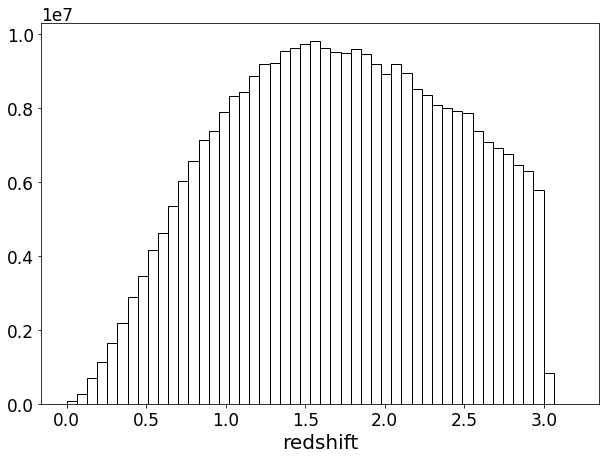

In [14]:
matplotlib.rcParams.update({'font.size': 17})
timer.start()

# Get min/max redshift values
m = df.select(F.min("redshift"), F.max("redshift")).first()
zmin, zmax = m[0], m[1]

# Number of bins, and spacings for our histogram
Nbins = 50
dz = (zmax - zmin) / Nbins
step = (zmax - zmin) / Nbins

# Add a columns of bins values
zbin = df.select(
    df["redshift"], 
    ((df["redshift"] - zmin - dz / 2) / dz).cast(IntegerType()).alias('bin'))

# GroupBy this column + count how many in each group (= histogram)
h = zbin.groupBy("bin").count().orderBy(F.asc("bin"))

# Add column of bin center locations + drop bin number
h = h.select("bin",(zmin + dz / 2 + h['bin'] * dz).alias('loc'), "count").drop("bin")

# Data is now reduced to a histogram so we can
# safely transfer back the data to the driver, in the pandas world 
hp = h.toPandas()

plt.figure(figsize=(10, 7))

plt.bar(hp['loc'].values, hp['count'].values, step, color='w', edgecolor='k')
plt.xlabel("redshift", fontsize=20)

timer.split()

In [15]:
hp.head()

,loc,count
0,0.032290,86956
1,0.096065,257609
2,0.159841,689886
3,0.223617,1120172
4,0.287392,1644021


Altoough you do not see it explicitely this is really **distributed** computing. You send the algorithm to the data (over each node) and recover the reduced values (histograms).

You are more used working the other way: you recover data in memory and run your algorithm

This can be emulated with the following piece of code where the "collect" function fills the driver memory and one then calls the classical hist function :


In [16]:
# plantage dans le collect
#timer.start()
#z_values = [_[0] for _ in df.select('redshift').collect()]
#plt.hist(z_values, range=(min(z_values), max(z_values)), bins=Nbins)
#plt.xlabel('redshift')
#timer.split()

As any comparison it is very unfair, since the driver here uses one thread, but it is also unfair to use Spark on such a low amount of data (42 millions)! But you got the idea of distributed (painless) computing that will prove its superiority for > 100GB data.

# A first 3D look

Since jupyter notebooks are not well suited to both intensive computation (CPU!) + intensive visualization (GPU!), we illustrate how it can be used from matplotlib but there are definitely more powerfull tools to do so (that we will discuss next).

In the following we make a 30 Mpc zoom centers on the mean position in the dataset, where we begin to see the cosmic web.

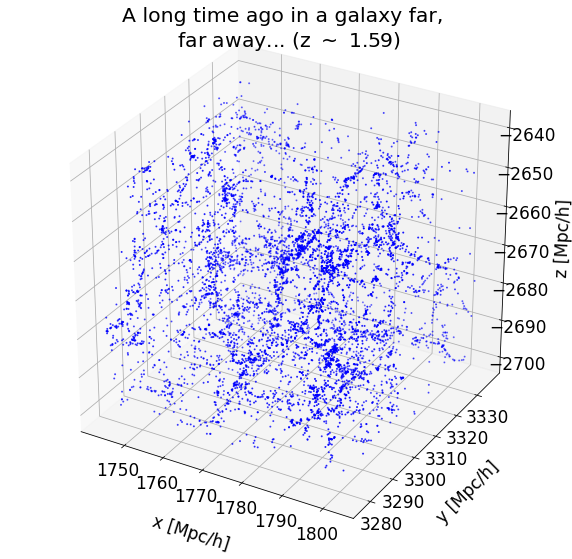

In [17]:
matplotlib.rcParams.update({'font.size': 17})

# Size of the box to display
Mpc = 30.

# Get the mean positions from the previous stat DataFrame
means = stat.collect()[1]
m_x = float(means['position_x'])
m_y = float(means['position_y'])
m_z = float(means['position_z'])

dfcut = df.filter( 
    (F.abs(df.position_x - m_x) < Mpc) &
    (F.abs(df.position_y - m_y) < Mpc) &
    (F.abs(df.position_z - m_z) < Mpc))

# Visualise it!
p = dfcut.toPandas()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(p.position_x, p.position_y, p.position_z, s=1,color='b')

ax.set_title('A long time ago in a galaxy far, \n far away... (z $\sim$ {:.2f})'.format(p.redshift.mean()))
ax.set_xlabel(r'x [Mpc/h]', labelpad=20)
ax.set_ylabel(r'y [Mpc/h]', labelpad=20)
ax.set_zlabel(r'z [Mpc/h]', labelpad=20)

plt.show()

# CosmoDC2 the movie!

By copying the data to the LAL cluster, using more sophisticated tools for vizualization and projecting data on our wall-of-screens we obtain the 
following MOVIE.
Note we also colored data according to their redshift (with a colormap that is held as secret as coca-cola receipe)

In [18]:
from IPython.display import HTML

# Display video from Youtube
HTML('<iframe width="700" height="600" src="https://www.youtube.com/embed/HC_CQA5cOag" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')